<a href="https://colab.research.google.com/github/SongziB612/HelloGitHub/blob/master/%E6%9D%8E%E7%BE%A4%E5%8F%AF%E8%A7%86%E5%8C%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install modern_robotics


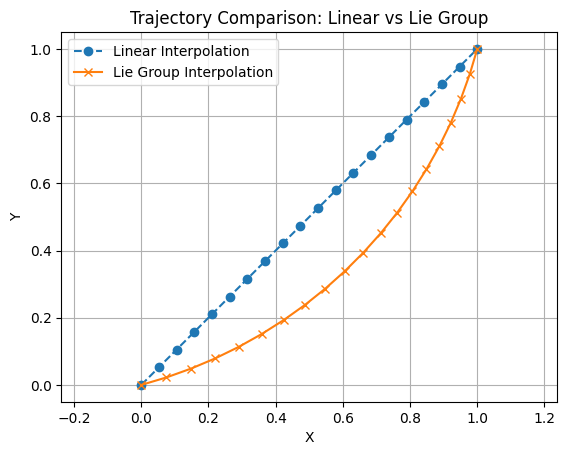

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from modern_robotics import MatrixLog6, MatrixExp6, TransInv, RpToTrans, TransToRp

# 初始位姿：旋转30度，平移 [0, 0, 0]
theta = np.pi / 6
R0 = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta),  0],
    [0,             0,              1]
])
t0 = np.array([[0], [0], [0]])
T0 = RpToTrans(R0, t0)

# 目标位姿：旋转90度，平移 [1, 1, 0]
theta2 = np.pi / 2
R1 = np.array([
    [np.cos(theta2), -np.sin(theta2), 0],
    [np.sin(theta2), np.cos(theta2),  0],
    [0,              0,               1]
])
t1 = np.array([[1], [1], [0]])
T1 = RpToTrans(R1, t1)

# -----------------------
# 方法一：传统线性插值（矩阵线性插值）
# -----------------------
def linear_interpolate(T0, T1, s):
    R0, p0 = TransToRp(T0)
    R1, p1 = TransToRp(T1)
    R = R0 + s * (R1 - R0)
    p = p0 + s * (p1 - p0)
    return RpToTrans(R, p)

# -----------------------
# 方法二：李代数插值
# -----------------------
def lie_group_interpolate(T0, T1, s):
    T_rel = np.dot(TransInv(T0), T1)
    se3mat = MatrixLog6(T_rel)          # 李代数元素
    T_interp = np.dot(T0, MatrixExp6(se3mat * s))
    return T_interp

# -----------------------
# 采样轨迹并可视化
# -----------------------
n_points = 20
traj_linear = []
traj_lie = []

for s in np.linspace(0, 1, n_points):
    T_lin = linear_interpolate(T0, T1, s)
    T_lie = lie_group_interpolate(T0, T1, s)
    traj_linear.append(T_lin[:3, 3])  # 只记录位置
    traj_lie.append(T_lie[:3, 3])

traj_linear = np.array(traj_linear)
traj_lie = np.array(traj_lie)

# -----------------------
# 可视化轨迹
# -----------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj_linear[:, 0], traj_linear[:, 1], label="Linear Interpolation", linestyle='--', marker='o')
ax.plot(traj_lie[:, 0], traj_lie[:, 1], label="Lie Group Interpolation", linestyle='-', marker='x')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Comparison: Linear vs Lie Group')
plt.axis('equal')
plt.grid(True)
plt.show()


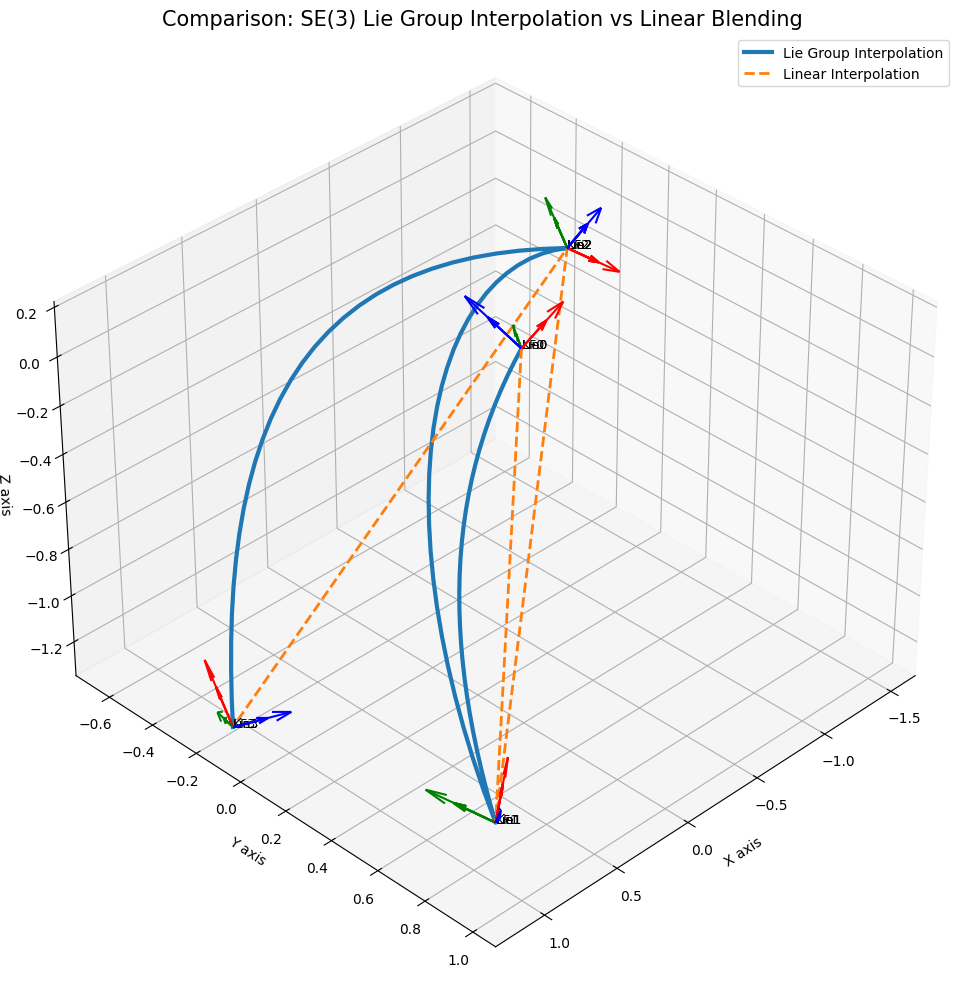

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from mpl_toolkits.mplot3d import Axes3D

def hat_se3(xi):
    w, v = xi[:3], xi[3:]
    wx = np.array([[0, -w[2], w[1]],
                   [w[2], 0, -w[0]],
                   [-w[1], w[0], 0]])
    mat = np.zeros((4, 4))
    mat[:3, :3] = wx
    mat[:3, 3] = v
    return mat

def random_pose(scale=1.0):
    A = np.random.randn(3,3)
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    t = np.random.uniform(-scale, scale, size=3)
    T = np.eye(4)
    T[:3,:3] = Q
    T[:3,3] = t
    return T

def interpolate_linear(T0, T1, s):
    R0, t0 = T0[:3,:3], T0[:3,3]
    R1, t1 = T1[:3,:3], T1[:3,3]
    R = R0 + s * (R1 - R0)
    U, _, Vt = np.linalg.svd(R)
    R = U @ Vt
    t = t0 + s * (t1 - t0)
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = t
    return T

def interpolate_lie(T0, T1, s):
    T_rel = np.linalg.inv(T0) @ T1
    xi_hat = logm(T_rel)
    T = T0 @ expm(s * xi_hat)
    return T

def draw_frame(ax, T, name=None, length=0.2):
    origin = T[:3,3]
    R = T[:3,:3]
    ax.quiver(*origin, *R[:,0]*length, color='r', label='x-axis' if name=="frame0" else "")
    ax.quiver(*origin, *R[:,1]*length, color='g', label='y-axis' if name=="frame0" else "")
    ax.quiver(*origin, *R[:,2]*length, color='b', label='z-axis' if name=="frame0" else "")
    if name:
        ax.text(*origin, name, fontsize=9)

# ===== Main Setup =====

num_keyframes = 4
steps = 30
scale = 1.5

waypoints = [random_pose(scale=scale) for _ in range(num_keyframes)]
traj_lie, traj_lin = [], []
frames_to_draw = []

for i in range(len(waypoints) - 1):
    T0, T1 = waypoints[i], waypoints[i+1]
    for s in np.linspace(0, 1, steps):
        T_lie = interpolate_lie(T0, T1, s)
        T_lin = interpolate_linear(T0, T1, s)
        traj_lie.append(T_lie[:3,3])
        traj_lin.append(T_lin[:3,3])
        if s == 0 or s == 1:
            frames_to_draw.append((T_lie, f"Lie{i if s==0 else i+1}"))
            frames_to_draw.append((T_lin, f"Lin{i if s==0 else i+1}"))

traj_lie = np.array(traj_lie)
traj_lin = np.array(traj_lin)

# ===== Visualization =====

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(traj_lie[:,0], traj_lie[:,1], traj_lie[:,2], '-', linewidth=3, label="Lie Group Interpolation")
ax.plot(traj_lin[:,0], traj_lin[:,1], traj_lin[:,2], '--', linewidth=2, label="Linear Interpolation")

for i, T in enumerate(waypoints):
    draw_frame(ax, T, name=f'KF{i}', length=0.25)

for T, name in frames_to_draw:
    draw_frame(ax, T, name=name, length=0.15)

ax.set_title("Comparison: SE(3) Lie Group Interpolation vs Linear Blending", fontsize=15)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.legend()
ax.grid(True)
ax.view_init(elev=35, azim=45)
plt.tight_layout()
plt.show()


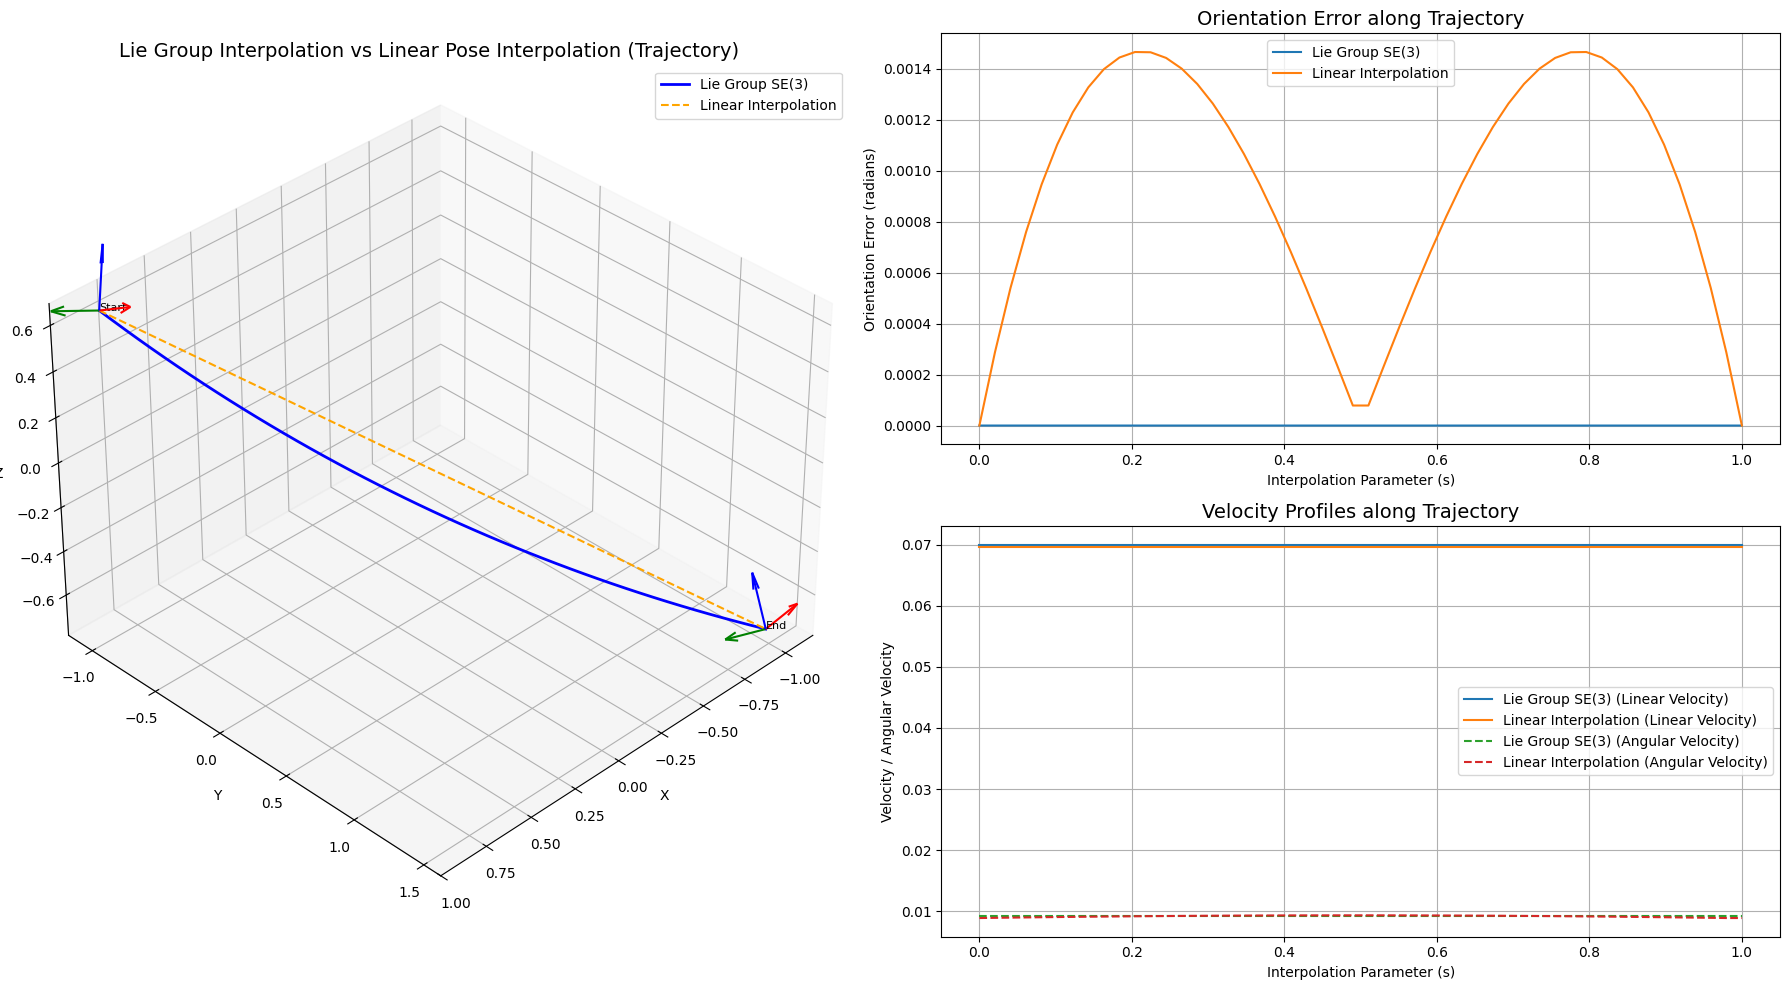

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rscipy # Import for orientation error calculation

# ---------- Lie Group Utilities ----------
def hat_se3(xi):
    omega, v = xi[:3], xi[3:]
    omega_hat = np.array([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])
    mat = np.zeros((4,4))
    mat[:3,:3] = omega_hat
    mat[:3,3] = v
    return mat

def log_SE3(T):
    return logm(T)

def exp_SE3(xi_hat):
    return expm(xi_hat)

def interpolate_SE3(T0, T1, s):
    T_rel = np.linalg.inv(T0) @ T1
    xi_hat = log_SE3(T_rel)
    T_interp = T0 @ exp_SE3(s * xi_hat)
    return T_interp

def interpolate_linear_pose(T0, T1, s):
    R0, t0 = T0[:3,:3], T0[:3,3]
    R1, t1 = T1[:3,:3], T1[:3,3]
    R = R0 + s * (R1 - R0)
    U, _, Vt = np.linalg.svd(R)
    R_interp = U @ Vt
    t_interp = (1 - s) * t0 + s * t1
    T = np.eye(4)
    T[:3,:3] = R_interp
    T[:3,3] = t_interp
    return T

# ---------- Generate Random Pose ----------
def random_SE3(scale=1.0):
    A = np.random.randn(3,3)
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    t = np.random.uniform(-scale, scale, 3)
    T = np.eye(4)
    T[:3,:3] = Q
    T[:3,3] = t
    return T

# ---------- Visualization ----------
def draw_frame(ax, T, name=None, length=0.2):
    origin = T[:3,3]
    R = T[:3,:3]
    ax.quiver(*origin, *R[:,0]*length, color='r')
    ax.quiver(*origin, *R[:,1]*length, color='g')
    ax.quiver(*origin, *R[:,2]*length, color='b')
    if name:
        ax.text(*origin, name, fontsize=8)

# ---------- Trajectory Generation ----------
def generate_trajectory(T0, T1, method_fn, steps=50):
    return [method_fn(T0, T1, s) for s in np.linspace(0, 1, steps)]

# ---------- Metrics ----------
def calculate_orientation_error(traj, T0, T1):
    errors = []
    R0 = T0[:3,:3]
    R1 = T1[:3,:3]
    log_R_rel = logm(R0.T @ R1)
    s_values = np.linspace(0, 1, len(traj))

    for i, T in enumerate(traj):
        R_interp = T[:3,:3]
        # Calculate the geodesic rotation on SO(3) at parameter s
        R_geo = R0 @ expm(s_values[i] * log_R_rel)
        # Calculate the angle between the interpolated rotation and the geodesic
        # Using the formula: angle = arccos((trace(R_interp.T @ R_geo) - 1) / 2)
        trace_val = np.trace(R_interp.T @ R_geo)
        # Clamp the trace value to the valid range [-1, 3] to avoid numerical issues
        trace_val_clamped = np.clip(trace_val, -1, 3)
        error = np.arccos((trace_val_clamped - 1) / 2)
        errors.append(error)
    return np.array(errors)


def calculate_velocity_profiles(traj, dt=1.0):
    velocities = []
    angular_velocities = []
    for i in range(len(traj) - 1):
        T_k = traj[i]
        T_k_plus_1 = traj[i+1]
        T_rel = np.linalg.inv(T_k) @ T_k_plus_1
        se3_element = logm(T_rel) / dt # Approximation of body velocity
        # Extract angular velocity (omega) and linear velocity (v) from se(3) element
        omega_hat = se3_element[:3,:3]
        omega = np.array([omega_hat[2,1], omega_hat[0,2], omega_hat[1,0]]) # Extract omega from skew-symmetric matrix
        v = se3_element[:3,3]

        angular_velocities.append(np.linalg.norm(omega)) # Magnitude of angular velocity
        velocities.append(np.linalg.norm(v)) # Magnitude of linear velocity

    # Append last value for consistent length (assuming constant velocity at the end)
    velocities.append(velocities[-1] if velocities else 0)
    angular_velocities.append(angular_velocities[-1] if angular_velocities else 0)

    return np.array(velocities), np.array(angular_velocities)


# ---------- Main ----------
T0 = random_SE3(scale=1.5)
T1 = random_SE3(scale=1.5)

traj_lie = generate_trajectory(T0, T1, interpolate_SE3)
traj_linear = generate_trajectory(T0, T1, interpolate_linear_pose)


# ---------- Plotting ----------
fig = plt.figure(figsize=(18, 10))

# 3D Trajectory Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Lie Group Interpolation vs Linear Pose Interpolation (Trajectory)", fontsize=14)
xyz_lie = np.array([T[:3,3] for T in traj_lie])
xyz_lin = np.array([T[:3,3] for T in traj_linear])
ax1.plot(xyz_lie[:,0], xyz_lie[:,1], xyz_lie[:,2], label="Lie Group SE(3)", color='blue', linewidth=2)
ax1.plot(xyz_lin[:,0], xyz_lin[:,1], xyz_lin[:,2], label="Linear Interpolation", color='orange', linestyle='--')
draw_frame(ax1, T0, "Start", length=0.25)
draw_frame(ax1, T1, "End", length=0.25)
ax1.legend()
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.view_init(elev=35, azim=45)
ax1.grid(True)


# Orientation Error Plot
ax2 = fig.add_subplot(222)
orientation_error_lie = calculate_orientation_error(traj_lie, T0, T1)
orientation_error_linear = calculate_orientation_error(traj_linear, T0, T1)
s_values = np.linspace(0, 1, len(traj_lie))
ax2.plot(s_values, orientation_error_lie, label="Lie Group SE(3)")
ax2.plot(s_values, orientation_error_linear, label="Linear Interpolation")
ax2.set_title("Orientation Error along Trajectory", fontsize=14)
ax2.set_xlabel("Interpolation Parameter (s)")
ax2.set_ylabel("Orientation Error (radians)")
ax2.legend()
ax2.grid(True)


# Velocity Profile Plot
ax3 = fig.add_subplot(224)
velocity_lie, angular_velocity_lie = calculate_velocity_profiles(traj_lie)
velocity_linear, angular_velocity_linear = calculate_velocity_profiles(traj_linear)

ax3.plot(s_values, velocity_lie, label="Lie Group SE(3) (Linear Velocity)")
ax3.plot(s_values, velocity_linear, label="Linear Interpolation (Linear Velocity)")
ax3.plot(s_values, angular_velocity_lie, label="Lie Group SE(3) (Angular Velocity)", linestyle='--')
ax3.plot(s_values, angular_velocity_linear, label="Linear Interpolation (Angular Velocity)", linestyle='--')

ax3.set_title("Velocity Profiles along Trajectory", fontsize=14)
ax3.set_xlabel("Interpolation Parameter (s)")
ax3.set_ylabel("Velocity / Angular Velocity")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

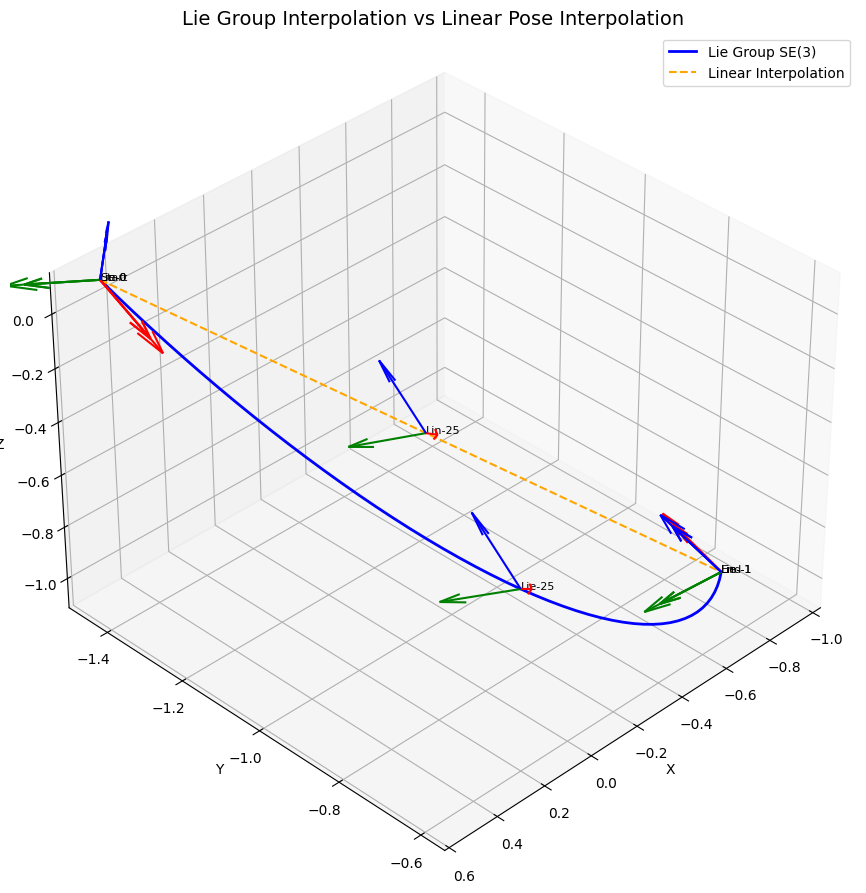

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from mpl_toolkits.mplot3d import Axes3D

# ---------- Lie Group Utilities ----------
def hat_se3(xi):
    omega, v = xi[:3], xi[3:]
    omega_hat = np.array([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])
    mat = np.zeros((4,4))
    mat[:3,:3] = omega_hat
    mat[:3,3] = v
    return mat

def log_SE3(T):
    return logm(T)

def exp_SE3(xi_hat):
    return expm(xi_hat)

def interpolate_SE3(T0, T1, s):
    T_rel = np.linalg.inv(T0) @ T1
    xi_hat = log_SE3(T_rel)
    T_interp = T0 @ exp_SE3(s * xi_hat)
    return T_interp

def interpolate_linear_pose(T0, T1, s):
    R0, t0 = T0[:3,:3], T0[:3,3]
    R1, t1 = T1[:3,:3], T1[:3,3]
    R = R0 + s * (R1 - R0)
    U, _, Vt = np.linalg.svd(R)
    R_interp = U @ Vt
    t_interp = (1 - s) * t0 + s * t1
    T = np.eye(4)
    T[:3,:3] = R_interp
    T[:3,3] = t_interp
    return T

# ---------- Generate Random Pose ----------
def random_SE3(scale=1.0):
    A = np.random.randn(3,3)
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    t = np.random.uniform(-scale, scale, 3)
    T = np.eye(4)
    T[:3,:3] = Q
    T[:3,3] = t
    return T

# ---------- Visualization ----------
def draw_frame(ax, T, name=None, length=0.2):
    origin = T[:3,3]
    R = T[:3,:3]
    ax.quiver(*origin, *R[:,0]*length, color='r')
    ax.quiver(*origin, *R[:,1]*length, color='g')
    ax.quiver(*origin, *R[:,2]*length, color='b')
    if name:
        ax.text(*origin, name, fontsize=8)

# ---------- Trajectory Generation ----------
def generate_trajectory(T0, T1, method_fn, steps=50):
    return [method_fn(T0, T1, s) for s in np.linspace(0, 1, steps)]

# ---------- Main ----------
T0 = random_SE3(scale=1.5)
T1 = random_SE3(scale=1.5)

traj_lie = generate_trajectory(T0, T1, interpolate_SE3)
traj_linear = generate_trajectory(T0, T1, interpolate_linear_pose)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Lie Group Interpolation vs Linear Pose Interpolation", fontsize=14)

# Plot trajectories
xyz_lie = np.array([T[:3,3] for T in traj_lie])
xyz_lin = np.array([T[:3,3] for T in traj_linear])
ax.plot(xyz_lie[:,0], xyz_lie[:,1], xyz_lie[:,2], label="Lie Group SE(3)", color='blue', linewidth=2)
ax.plot(xyz_lin[:,0], xyz_lin[:,1], xyz_lin[:,2], label="Linear Interpolation", color='orange', linestyle='--')

# Plot coordinate frames at intervals
for i in [0, len(traj_lie)//2, -1]:
    draw_frame(ax, traj_lie[i], name=f"Lie-{i}")
    draw_frame(ax, traj_linear[i], name=f"Lin-{i}")

draw_frame(ax, T0, "Start", length=0.25)
draw_frame(ax, T1, "End", length=0.25)

ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=35, azim=45)
ax.grid(True)
plt.tight_layout()
plt.show()


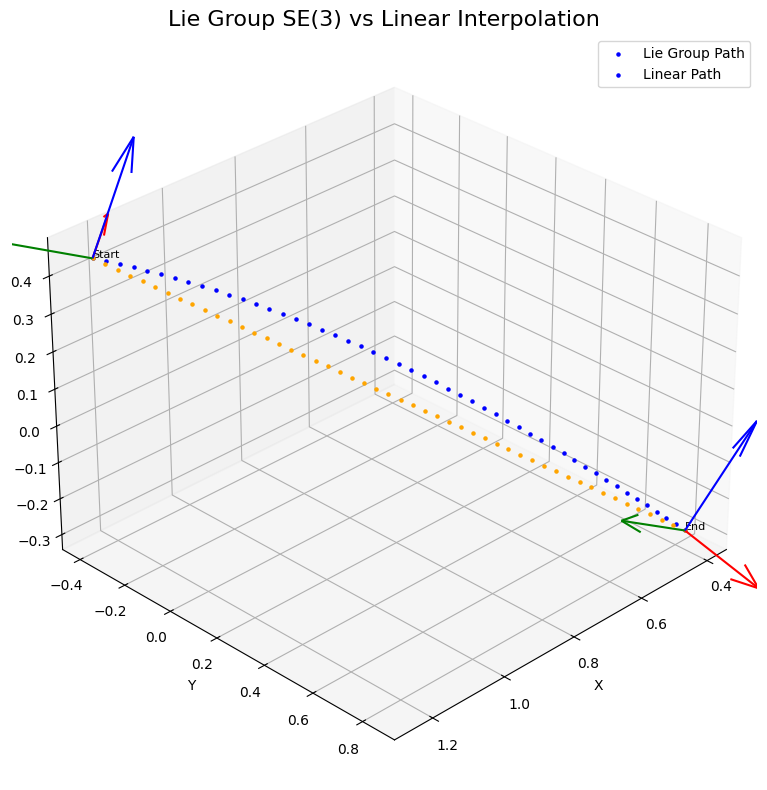

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from mpl_toolkits.mplot3d import Axes3D

# === Lie Algebra Utilities ===
def hat_se3(xi):
    w, v = xi[:3], xi[3:]
    wx = np.array([
        [0, -w[2], w[1]],
        [w[2], 0, -w[0]],
        [-w[1], w[0], 0]
    ])
    mat = np.zeros((4, 4))
    mat[:3, :3] = wx
    mat[:3, 3] = v
    return mat

def interpolate_lie(T0, T1, s):
    T_rel = np.linalg.inv(T0) @ T1
    xi_hat = logm(T_rel)
    return T0 @ expm(s * xi_hat)

def interpolate_linear(T0, T1, s):
    R0, t0 = T0[:3, :3], T0[:3, 3]
    R1, t1 = T1[:3, :3], T1[:3, 3]
    R_interp = R0 + s * (R1 - R0)
    # Re-orthogonalize
    U, _, Vt = np.linalg.svd(R_interp)
    R_orthogonal = U @ Vt
    t_interp = t0 + s * (t1 - t0)
    T_interp = np.eye(4)
    T_interp[:3, :3] = R_orthogonal
    T_interp[:3, 3] = t_interp
    return T_interp

# === Generate Random SE(3) Transform ===
def random_SE3(scale=1.5):
    A = np.random.randn(3, 3)
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0: Q[:, 0] *= -1
    t = np.random.uniform(-scale, scale, 3)
    T = np.eye(4)
    T[:3, :3] = Q
    T[:3, 3] = t
    return T

# === Draw Coordinate Frame ===
def draw_frame(ax, T, name=None, length=0.2):
    origin = T[:3, 3]
    x, y, z = T[:3, :3].T * length
    ax.quiver(*origin, *x, color='r')
    ax.quiver(*origin, *y, color='g')
    ax.quiver(*origin, *z, color='b')
    if name:
        ax.text(*origin, name, fontsize=8)

# === Generate Interpolated Trajectories ===
T0, T1 = random_SE3(), random_SE3()
steps = 50
traj_lie = [interpolate_lie(T0, T1, s) for s in np.linspace(0, 1, steps)]
traj_lin = [interpolate_linear(T0, T1, s) for s in np.linspace(0, 1, steps)]

# === Plotting ===
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

for T in traj_lie:
    ax.scatter(*T[:3, 3], color='blue', s=5)
for T in traj_lin:
    ax.scatter(*T[:3, 3], color='orange', s=5)

draw_frame(ax, T0, name="Start", length=0.3)
draw_frame(ax, T1, name="End", length=0.3)

ax.set_title("Lie Group SE(3) vs Linear Interpolation", fontsize=16)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend(["Lie Group Path", "Linear Path"])
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()


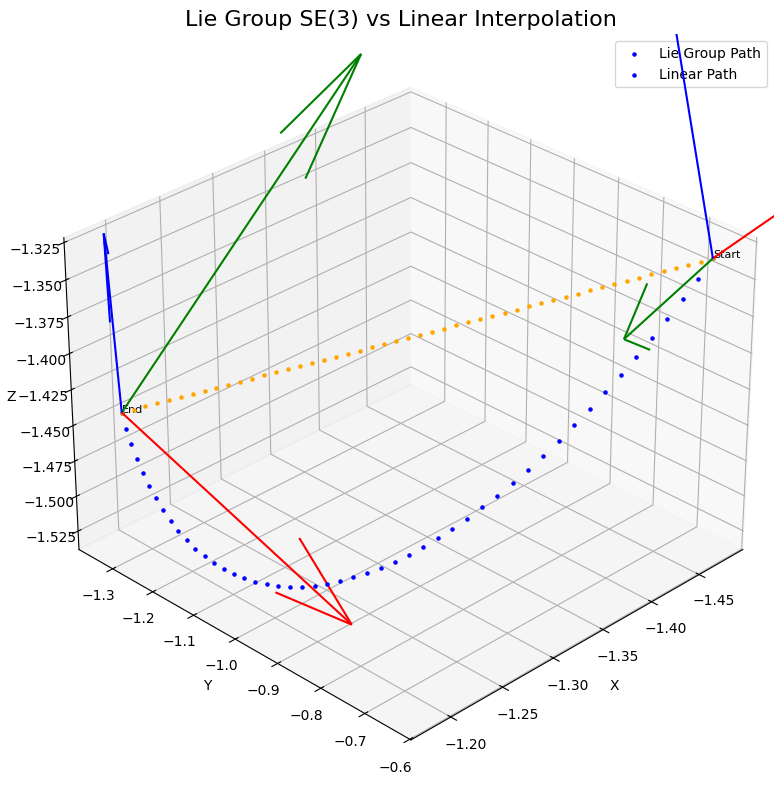

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from mpl_toolkits.mplot3d import Axes3D

# === Lie Algebra Utilities ===
def hat_se3(xi):
    w, v = xi[:3], xi[3:]
    wx = np.array([
        [0, -w[2], w[1]],
        [w[2], 0, -w[0]],
        [-w[1], w[0], 0]
    ])
    mat = np.zeros((4, 4))
    mat[:3, :3] = wx
    mat[:3, 3] = v
    return mat

def interpolate_lie(T0, T1, s):
    T_rel = np.linalg.inv(T0) @ T1
    xi_hat = logm(T_rel)
    return T0 @ expm(s * xi_hat)

def interpolate_linear(T0, T1, s):
    R0, t0 = T0[:3, :3], T0[:3, 3]
    R1, t1 = T1[:3, :3], T1[:3, 3]
    R_interp = R0 + s * (R1 - R0)
    # Re-orthogonalize
    U, _, Vt = np.linalg.svd(R_interp)
    R_orthogonal = U @ Vt
    t_interp = t0 + s * (t1 - t0)
    T_interp = np.eye(4)
    T_interp[:3, :3] = R_orthogonal
    T_interp[:3, 3] = t_interp
    return T_interp

# === Generate Random SE(3) Transform ===
def random_SE3(scale=1.5):
    A = np.random.randn(3, 3)
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0: Q[:, 0] *= -1
    t = np.random.uniform(-scale, scale, 3)
    T = np.eye(4)
    T[:3, :3] = Q
    T[:3, 3] = t
    return T

# === Draw Coordinate Frame ===
def draw_frame(ax, T, name=None, length=0.2):
    origin = T[:3, 3]
    x, y, z = T[:3, :3].T * length
    ax.quiver(*origin, *x, color='r')
    ax.quiver(*origin, *y, color='g')
    ax.quiver(*origin, *z, color='b')
    if name:
        ax.text(*origin, name, fontsize=8)

# === Generate Interpolated Trajectories ===
T0, T1 = random_SE3(), random_SE3()
steps = 50
traj_lie = [interpolate_lie(T0, T1, s) for s in np.linspace(0, 1, steps)]
traj_lin = [interpolate_linear(T0, T1, s) for s in np.linspace(0, 1, steps)]

# === Plotting ===
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

for T in traj_lie:
    ax.scatter(*T[:3, 3], color='blue', s=5)
for T in traj_lin:
    ax.scatter(*T[:3, 3], color='orange', s=5)

draw_frame(ax, T0, name="Start", length=0.3)
draw_frame(ax, T1, name="End", length=0.3)

ax.set_title("Lie Group SE(3) vs Linear Interpolation", fontsize=16)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend(["Lie Group Path", "Linear Path"])
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()
